# JODA 2021 Harjoitustyö - Simo Uusijoki

## Alkuvalmistelut (Kehitysympäristön valinta)

Päätin valita kehitysympäristöksi Anaconda Navigatorin. Luentoja seuraamalla ja googlettemalla tämä tuntui olevan virtaviivainen tapa edetä. Ajattelin aluksi käyttää CSC Notebooks -ympäristöä suoraan, mutta tässä olevat rajoitteet (yhden ympäristön käyttö muutama tunti kerrallaan) saivat minut tutustumaan Anaconda Navigatoriin. Asennus sujui helposti alla olevan linkin avulla. Kokeilin myös Jupyter Notebook -tiedoston luomista harjoitustyötä varten ja myös tämä luonnistui näppärästi.
Alla vielä kuvat Anaconda Navigaattorista sekä Jupyter Notebookista.

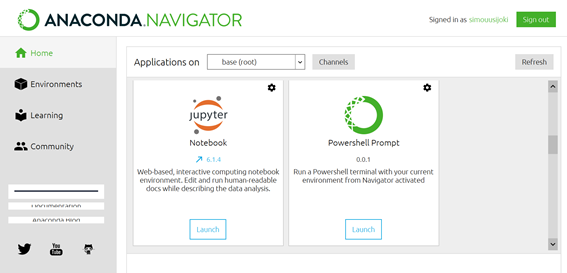

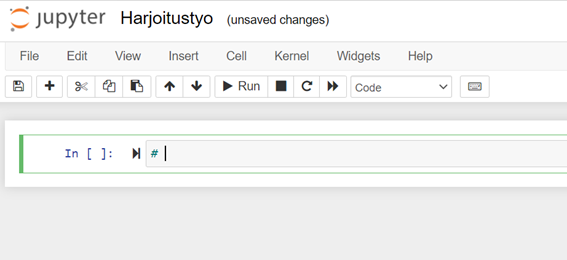


Tuodaan pandas kirjasto osaksi harjoitustyötä.

In [1]:
import pandas as pd

## Datan kerääminen

Pohdinnan jälkeen päätin vaihtaa oman terveysdatan tutkimisen Airbnb:n valmiiseen datasettiin. Johtuen kurssiin käytettävän ajan rajallisuudesta ja oman kokemuspohjan ohuudesta liittyen datatieteeseen, olisi oman datasetin kanssa työskentely saattaanut muotoutua liian aikaa vieväksi harjoitukseksi. Päädyin kuitenkin ottamaan datan kahdelta eri vuodelta ja yhdistelemään nämä, jotta pystyn vertailemaan tilannetta ennen koronaa (2019_02) ja koronan aikana (2021_02). Milanon data valikoitua, koska Italian Lombardian alue on yksi koko maailman pahimpia korona-alueita, joten datassa luulisi näkyvän jotain mielenkiintoista.

Tutkimuksen kohteena tulee siis olemaan vuokrattavien asuntojen hinnat ennen koronaa ja koronan aikana, sekä hintoihin vaikuttavat tekijät.

Datan latasin siis Inside Airbnbstä ja dataseteistä valitsin listings.csv.gz, joka vaikutti kaikkein suurimmalta ja monikäyttöisimmältä datalta. Tämä siis molempien datasettien valinta.

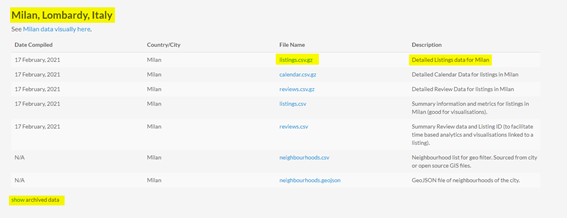

In [2]:
import numpy as np
import matplotlib as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

# Reading our dataset into a dataframe

URL2021= 'http://data.insideairbnb.com/italy/lombardy/milan/2021-02-17/data/listings.csv.gz'
df2021= pd.read_csv(URL2021, compression='gzip')

URL2019= 'http://data.insideairbnb.com/italy/lombardy/milan/2019-02-07/data/listings.csv.gz'
df2019= pd.read_csv(URL2019, compression='gzip')

# Check data, print columns
       
print(df2021.head())
print(df2021.columns.tolist())

print(df2019.head())
print(df2019.columns.tolist())



      id                         listing_url       scrape_id last_scraped  \
0   6400   https://www.airbnb.com/rooms/6400  20210217171707   2021-02-19   
1  17232  https://www.airbnb.com/rooms/17232  20210217171707   2021-02-19   
2  18429  https://www.airbnb.com/rooms/18429  20210217171707   2021-02-19   
3  23986  https://www.airbnb.com/rooms/23986  20210217171707   2021-02-19   
4  32119  https://www.airbnb.com/rooms/32119  20210217171707   2021-02-20   

                                 name  \
0                    The Studio Milan   
1         MPX-Center-EXPO Value/Money   
2    Best Opportunity MPX-EXPO-CENTER   
3     " Characteristic Milanese flat"   
4  Nico & Cynthia's Easy Yellow Suite   

                                         description  \
0  Enjoy your stay at The Studio, a light-filled ...   
1  convenient , easy, cozy<br />best english and ...   
2  whole apartment<br />cosy<br />convenient<br /...   
3  I look forward to welcoming you in my flat; it...   
4  <b>The 

C:\Users\simo.uusijoki\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Check data quantity 2021
len (df2021.index)


18367

In [4]:
# Check data quantity 2019
len (df2019.index)

17823

Päätin myös jo siivota turhat sarakkeet datasta pois ja tätä varten käytiin alla olevaa koodia. Tämän jälkeen otin sarakkeet exceliin, jossa näitä oli helpompi katsella. Huomasin, että 2019 ja 2021 datat eivät täysin vastanneet toisiaan, mutta sieltä löytyi sopivat sarakkeet joita jatkotarkastella.

In [5]:
# Select columns want to be kept

cols = ['id',
'host_is_superhost',
'neighbourhood_cleansed',
'room_type',
'accommodates',
'bedrooms',
'beds',
'price',
'number_of_reviews',
'review_scores_rating',
'availability_365'
]


# read the file and make data frames to have only columns selected above

df2021 = pd.read_csv(URL2021, usecols=cols, compression='gzip')
df2019 = pd.read_csv(URL2019, usecols=cols, compression='gzip')

# Let's check if we have only wanted columns included

print(df2021.columns.tolist())
print(df2019.columns.tolist())


['id', 'host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'availability_365', 'number_of_reviews', 'review_scores_rating']
['id', 'host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'availability_365', 'number_of_reviews', 'review_scores_rating']


Tästä sitten jatketaan datan siivoamiseen sekä yhdistelyyn yhdeksi datasetiksi (koska sarakkeet yhden mukaiset).

## Datan jalostaminen
Tässä osiossa jalostetaan yllä hankittua Milanon Airbnb-dataa vuosilta 2019 (ennen koronaa) ja 2021 (koronan aikana). Yhdistän nuo kaksi datasettiä (molemmissa jo aiemmin samat sarakkeet) ja tutkin mitä arvoja valitut sarakkeet saavat. Sarakkeiden tietojen perusteella teen siivousta ja teen piirteiden tunnistamista.

Ensiksi lisään molempiin datasetteihin (2019 ja 2021) uuden sarakkeen ”Year”, jotta voidaan datasettien yhdistämisen jälkeen nähdä mitä vuotta rivit koskevat.

In [6]:
# Adding column "Year" to both datasets with corresponding year values

df2021 ['Year'] = 2021
df2019 ['Year'] = 2019

In [7]:
# Let's check our columns now to see if we have new column there

print(df2021.columns.tolist())
print(df2019.columns.tolist())

['id', 'host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'Year']
['id', 'host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'Year']


In [8]:
# Let's check what kind of values we have within our just created columns

print(df2021.head())
print(df2019.head())

      id host_is_superhost neighbourhood_cleansed        room_type  \
0   6400                 f                TIBALDI     Private room   
1  17232                 f                 BOVISA      Shared room   
2  18429                 f                 BOVISA  Entire home/apt   
3  23986                 f                NAVIGLI  Entire home/apt   
4  32119                 f            VIALE MONZA  Entire home/apt   

   accommodates  bedrooms  beds    price  availability_365  number_of_reviews  \
0             1       3.0   1.0  $100.00               358                 12   
1             2       1.0   2.0   $24.00               179                 55   
2             4       2.0   2.0  $150.00               267                  1   
3             4       1.0   1.0  $150.00               363                 15   
4             4       1.0   4.0   $75.00               234                 15   

   review_scores_rating  Year  
0                  98.0  2021  
1                  89.0  202

Tämän jälkeen yhdistän kaksi datasettiä yhdeksi.

In [9]:
dfMilan = df2019.append(df2021)
print(dfMilan.head())

      id host_is_superhost neighbourhood_cleansed        room_type  \
0   6400                 f                TIBALDI     Private room   
1  23986                 f                NAVIGLI  Entire home/apt   
2  28300                 f                  SARPI     Private room   
3  32119                 f            VIALE MONZA  Entire home/apt   
4  32649                 f            VIALE MONZA  Entire home/apt   

   accommodates  bedrooms  beds    price  availability_365  number_of_reviews  \
0             1       3.0   1.0  $100.00               349                 11   
1             4       1.0   2.0  $150.00               355                 12   
2             2       1.0   2.0  $200.00               365                  8   
3             4       1.0   4.0   $70.00               270                 15   
4             4       1.0   3.0   $70.00               302                 28   

   review_scores_rating  Year  
0                  98.0  2019  
1                  91.0  201

Nyt saimme yhdistettyä datasetit yhdeksi "dfMilan" setiksi. Katsotaan vielä, (1) että uusi sarake on mukana

In [10]:
print(dfMilan.columns.tolist())

['id', 'host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'Year']


ja (2) meillä on datassa kahden datasetin rivit 18367 + 17823 = 36190

In [11]:
len (dfMilan.index)

36190

Hyvältä näyttää. Tässä vaiheessa on myös todettava, että tutkimukseen vuosien 2019 ja 2021 helmikuun Milanon ilmoitusten yhdistämisestä ei tule päällekkäisyyttä. Tämä koska,

(1) Datasetit df2019 ja df2021 ovat kyseisen ajanhetken ilmoitetut vuokrattavissa olevat asunnot (=tietyn hetken tilanne)

(2) Tutkimuksessa katsotaan kuinka eri vuosien pyyntihinnat ovat vaihdelleet, jolloin data vertailu vuosien välillä on relevantti tapa

Voimme siis edetä kohti datan siivoamista. Ensimmäisenä katsotaan mitä datatyyppejä datassa on

In [12]:
display(dfMilan.dtypes)

id                          int64
host_is_superhost          object
neighbourhood_cleansed     object
room_type                  object
accommodates                int64
bedrooms                  float64
beds                      float64
price                      object
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
Year                        int64
dtype: object

Katsotaan vielä millaisia arvoja sarakkeet saavat, jotta osataan korjata oikeiksi datatyypeiksi

In [13]:
dfMilan.describe(include='all')

,id,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_365,number_of_reviews,review_scores_rating,Year
count,3.619000e+04,36184,36190,36190,36190.000000,34747.000000,36013.000000,36190,36190.000000,36190.000000,26845.000000,36190.000000
unique,NaN,2,87,4,NaN,NaN,NaN,522,NaN,NaN,NaN,NaN
top,NaN,f,BUENOS AIRES - VENEZIA,Entire home/apt,NaN,NaN,NaN,$50.00,NaN,NaN,NaN,NaN
freq,NaN,29881,2867,26553,NaN,NaN,NaN,1887,NaN,NaN,NaN,NaN
mean,2.043238e+07,NaN,NaN,NaN,3.044598,1.212680,1.826063,NaN,159.091821,24.893921,93.432706,2020.015032
std,1.281839e+07,NaN,NaN,NaN,1.546823,0.634316,1.200731,NaN,139.121574,55.450113,8.892937,0.999901
min,6.400000e+03,NaN,NaN,NaN,1.000000,0.000000,0.000000,NaN,0.000000,0.000000,20.000000,2019.000000
25%,8.365608e+06,NaN,NaN,NaN,2.000000,1.000000,1.000000,NaN,2.000000,1.000000,91.000000,2019.000000
50%,2.077960e+07,NaN,NaN,NaN,3.000000,1.000000,2.000000,NaN,139.000000,4.000000,96.000000,2021.000000
75%,2.993723e+07,NaN,NaN,NaN,4.000000,1.000000,2.000000,NaN,307.000000,22.000000,100.000000,2021.000000


Huomataan, että datatyyppinä on "object" numeerisen sarakkeen price kohdalla, muutetaan tämä float64 tyyppiin sekä poistetaan dollarimerkit.  

In [14]:
dfMilan['price'] = dfMilan['price'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

Katsotaan miltä data nyt näyttää

In [15]:
display(dfMilan.dtypes)
print(dfMilan.head())

id                          int64
host_is_superhost          object
neighbourhood_cleansed     object
room_type                  object
accommodates                int64
bedrooms                  float64
beds                      float64
price                     float64
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
Year                        int64
dtype: object

      id host_is_superhost neighbourhood_cleansed        room_type  \
0   6400                 f                TIBALDI     Private room   
1  23986                 f                NAVIGLI  Entire home/apt   
2  28300                 f                  SARPI     Private room   
3  32119                 f            VIALE MONZA  Entire home/apt   
4  32649                 f            VIALE MONZA  Entire home/apt   

   accommodates  bedrooms  beds  price  availability_365  number_of_reviews  \
0             1       3.0   1.0  100.0               349                 11   
1             4       1.0   2.0  150.0               355                 12   
2             2       1.0   2.0  200.0               365                  8   
3             4       1.0   4.0   70.0               270                 15   
4             4       1.0   3.0   70.0               302                 28   

   review_scores_rating  Year  
0                  98.0  2019  
1                  91.0  2019  
2       

Seuraavaksi katsotaan onko joukossa "nollarivejä" jotka voisivat sotkea datan tulkinnan 

In [16]:
print(dfMilan.isnull().sum())

id                           0
host_is_superhost            6
neighbourhood_cleansed       0
room_type                    0
accommodates                 0
bedrooms                  1443
beds                       177
price                        0
availability_365             0
number_of_reviews            0
review_scores_rating      9345
Year                         0
dtype: int64


Lisäksi poistetaan nollarivit, jos datassa ei ole mainittu Bedrooms, beds, host_is_superhost arvoja. Tiputetaan myös, jos review_scores_rating saa arvon nolla.

In [17]:
dfMilan = dfMilan[dfMilan.bedrooms !=0]
dfMilan = dfMilan[dfMilan.beds !=0]
dfMilan = dfMilan[dfMilan.review_scores_rating !=0]
dfMilan = dfMilan.dropna(axis=0)

print(dfMilan.isnull().sum())
len (dfMilan.index)

id                        0
host_is_superhost         0
neighbourhood_cleansed    0
room_type                 0
accommodates              0
bedrooms                  0
beds                      0
price                     0
availability_365          0
number_of_reviews         0
review_scores_rating      0
Year                      0
dtype: int64


24334

## Datan kuvaileminen

Tässä osiossa katsotaan eri graafien avulla kuinka 2019 ja 2021 vuoden Milanon hinnat ovat vaihdelleet. Lisäsin myös sarakkeen "availability_365" jonka olin epähuomiossa jättänyt tarkastelun ulkopuolelle, tämä antaa myös osviittaa edellisen kalenterivuoden asuntojen menekistä. Vuoden 2021 datassa tietenkin oletuksena on, että koronan vaikutukset näkyvät sekä hinnassa, että myös asuntojen käyttöasteesst (=availability).

Ensiksi tarkastellaan huonetyyppejä.

<AxesSubplot:title={'center':'Room type'}>

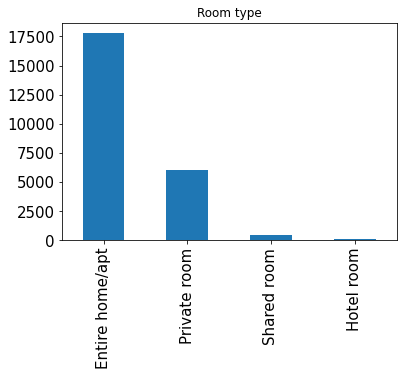

In [18]:
plt.title('Room type')
dfMilan['room_type'].value_counts().plot(kind='bar', fontsize=15)


Eli selkeästi eniten vuokrataan koko huoneistoja/asuntoja. Rajaamme jatkossa tarkatelun koskemaan ainoastaan "Entire home/apt" kohteita.

Seuraavaksi katsomme millä alueilla asunnot ovat.

<AxesSubplot:title={'center':'Asuinalue'}>

C:\Users\simo.uusijoki\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\simo.uusijoki\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)


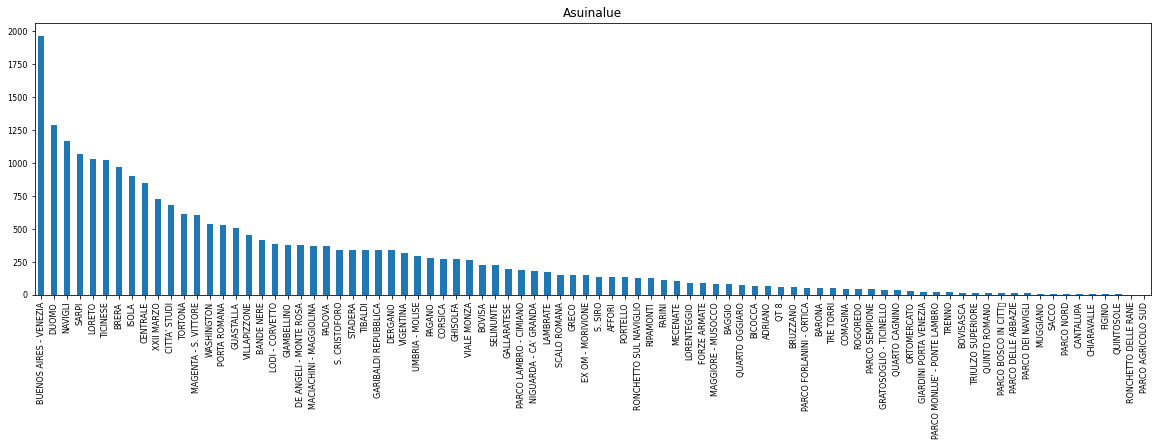

In [19]:
plt.title('Asuinalue')
dfMilan['neighbourhood_cleansed'].value_counts().plot(kind='bar', fontsize=8, figsize=(20,5))

Suurin tarjonta on alueella "Buenos Aires - Venezia" joka pienen selvittelyn jälkeen osoittautui olemaan yllätyksettömästi keskeisellä paikalla, usean nähtävyyden ja keskustan shoppailu- sekä ravintolapalveluiden lähellä.

Keskitytään jatkossa top10 alueisiin, jossa eniten tarjontaa yhdistetyssä datasetissä.

In [20]:
neighbours = dfMilan['neighbourhood_cleansed'].unique()
print(neighbours)

['TIBALDI' 'NAVIGLI' 'SARPI' 'VIALE MONZA' 'GUASTALLA' 'TICINESE'
 'BUENOS AIRES - VENEZIA' 'GIAMBELLINO' 'CENTRALE' 'XXII MARZO' 'BRERA'
 'DUOMO' 'ISOLA' 'BANDE NERE' 'WASHINGTON' 'PORTA ROMANA' 'LAMBRATE'
 'VILLAPIZZONE' 'MACIACHINI - MAGGIOLINA' "CITTA' STUDI" 'GHISOLFA'
 'STADERA' 'S. SIRO' 'S. CRISTOFORO' 'PARCO LAMBRO - CIMIANO' 'PADOVA'
 'CORSICA' 'LORETO' 'DE ANGELI - MONTE ROSA' 'BOVISA' 'VIGENTINA'
 'BOVISASCA' 'TORTONA' 'LORENTEGGIO' 'UMBRIA - MOLISE' 'BAGGIO'
 'GRATOSOGLIO - TICINELLO' 'MAGENTA - S. VITTORE' 'GARIBALDI REPUBBLICA'
 'PORTELLO' 'SACCO' 'PAGANO' 'TRE TORRI' 'PARCO FORLANINI - ORTICA'
 'LODI - CORVETTO' 'RIPAMONTI' 'FORZE ARMATE' 'BARONA' 'DERGANO' 'FARINI'
 "NIGUARDA - CA' GRANDA" 'GRECO' 'GALLARATESE' 'QT 8'
 'GIARDINI PORTA VENEZIA' 'QUARTO OGGIARO' 'MAGGIORE - MUSOCCO' 'BRUZZANO'
 'PARCO SEMPIONE' 'COMASINA' 'ADRIANO' 'EX OM - MORIVIONE' 'QUINTO ROMANO'
 'RONCHETTO SUL NAVIGLIO' 'SCALO ROMANA' 'PARCO DEI NAVIGLI' 'SELINUNTE'
 'QUARTO CAGNINO' 'MECENATE' 'RO

In [21]:
# top10 = 'BUENOS AIRES - VENEZIA','DUOMO','NAVIGLI','SARPI','LORETO','TICINESE', 'BRERA', 'ISOLA','CENTRALE','XXII MARZO']
  
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='TIBALDI']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='VIALE MONZA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GUASTALLA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GIAMBELLINO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='BANDE NERE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='WASHINGTON']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PORTA ROMANA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='LAMBRATE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='MACIACHINI - MAGGIOLINA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !="CITTA' STUDI"]
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GHISOLFA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='STADERA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='S. SIRO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='S. CRISTOFORO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO LAMBRO - CIMIANO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PADOVA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='CORSICA' 'LORETO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='DE ANGELI - MONTE ROSA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='BOVISA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='VIGENTINA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='BOVISASCA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='LORENTEGGIO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='UMBRIA - MOLISE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='BAGGIO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GRATOSOGLIO - TICINELLO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='MAGENTA - S. VITTORE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GARIBALDI REPUBBLICA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PORTELLO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='SACCO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PAGANO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='TRE TORRI']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO FORLANINI - ORTICA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='LODI - CORVETTO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='RIPAMONTI']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='FORZE ARMATE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='BARONA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='DERGANO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='FARINI']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !="NIGUARDA - CA' GRANDA"]
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GRECO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GALLARATESE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='QT 8']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='GIARDINI PORTA VENEZIA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='QUARTO OGGIARO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='MAGGIORE - MUSOCCO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PANE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='QUINTO ROMANO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='RONCHETTO SUL NO ROMAN']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO DEI NAVIGLI']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='VILLAPIZZONE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='CORSICA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='TORTONA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='BRUZZANO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO SEMPIONE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='COMASINA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='ADRIANO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='EX OM - MORIVIONE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='RONCHETTO SUL NAVIGLIO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='SCALO ROMANA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='SELINUNTE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='QUARTO CAGNINO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='MECENATE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='ROGOREDO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='AFFORI']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='MUGGIANO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='TRIULZO SUPERIORE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !="PARCO MONLUE' - PONTE LAMBRO"]
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO BOSCO IN CITT\x85']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO DELLE ABBAZIE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='RONCHETTO DELLE RANE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='ORTOMERCATO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO NORD']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='BICOCCA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='CANTALUPA']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='TRENNO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='FIGINO']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='CHIARAVALLE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='QUINTOSOLE']
dfMilan = dfMilan[dfMilan.neighbourhood_cleansed !='PARCO AGRICOLO SUD']
                  
neighbours = dfMilan['neighbourhood_cleansed'].unique()
print(neighbours)

['NAVIGLI' 'SARPI' 'TICINESE' 'BUENOS AIRES - VENEZIA' 'CENTRALE'
 'XXII MARZO' 'BRERA' 'DUOMO' 'ISOLA' 'LORETO']


Vertaillaan nyt vuosien 2019 ja 2021 dataa valituilla alueilla. Katsotaan ensiksi ilmoitusten määrää.

In [22]:
dfMilan_comparison1 = pd.crosstab(dfMilan['neighbourhood_cleansed'],dfMilan['Year'])
dfMilan_comparison1

Year,2019,2021
neighbourhood_cleansed,,
BRERA,499,473
BUENOS AIRES - VENEZIA,1040,922
CENTRALE,439,410
DUOMO,629,655
ISOLA,454,446
LORETO,523,504
NAVIGLI,613,556
SARPI,532,536
TICINESE,517,507


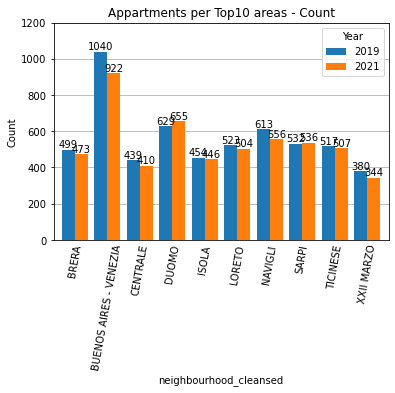

In [23]:
dfMilan_comparison1.plot.bar(width = 0.8, rot = 80, zorder = 2)

plt.title('Appartments per Top10 areas - Count')
plt.ylabel('Count')

plt.grid(axis = 'y')
plt.tick_params(axis = 'x', length = 0)
plt.ylim(0, 1200)

for bar in plt.gca().patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    label = '{:.0f}'.format(y)
    plt.text(x = x, y = y + 0.3, s = label, va = 'bottom', ha = 'center')


Yleisesti voidaan sanoa, että 2021 asuntoja on hiukan vähemmän tarjolla kuin 2019, mutta ero ei ole suuri. Katsotaan seuraavaksi kuinka keskihinta on kehittynyt vuosien välillä.

In [24]:
dfMilan_comparison2 = pd.crosstab(dfMilan['neighbourhood_cleansed'],dfMilan['Year'], values=dfMilan.price, aggfunc='mean')
dfMilan_comparison2

Year,2019,2021
neighbourhood_cleansed,,
BRERA,157.883768,193.391121
BUENOS AIRES - VENEZIA,94.723077,106.629067
CENTRALE,101.772210,92.543902
DUOMO,188.616852,153.393893
ISOLA,92.493392,103.681614
LORETO,69.938815,74.615079
NAVIGLI,94.924959,111.712230
SARPI,107.781955,105.576493
TICINESE,101.876209,117.927022


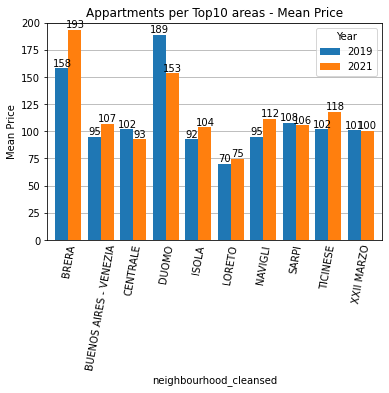

In [25]:
dfMilan_comparison2.plot.bar(width = 0.8, rot = 80, zorder = 2)

plt.title('Appartments per Top10 areas - Mean Price')
plt.ylabel('Mean Price')

plt.grid(axis = 'y')
plt.tick_params(axis = 'x', length = 0)
plt.ylim(0, 200)

for bar in plt.gca().patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    label = '{:.0f}'.format(y)
    plt.text(x = x, y = y + 0.3, s = label, va = 'bottom', ha = 'center')

Bredassa keskihinta on merkittävästi noussut ja Duomossa merkittävästi laskenut. Muilla aluiella keskihintamuutokset ovat maltillisia. Kuitenkin näyttäisi, että suuremmassa osassa alueista keskihinnat ovat kuitenkin kohonneet vuodesta 2019. Ajattelin itse, että pandemian vaikutuksesta hinnat olisivat Milanossa laskeneet, mutta olin ilmeisen väärässä.

Katsotaan vielä kuinka saatavissa asunnot ovat olleet listausta edeltäneen vuoden aikana, jotta selviää onko kysynnässä ollut pandemian aikana muutosta.

In [26]:
dfMilan_comparison3 = pd.crosstab(dfMilan['neighbourhood_cleansed'],dfMilan['Year'], values=dfMilan.availability_365, aggfunc='mean')
dfMilan_comparison3

Year,2019,2021
neighbourhood_cleansed,,
BRERA,185.613226,149.498943
BUENOS AIRES - VENEZIA,173.490385,150.599783
CENTRALE,194.439636,169.851220
DUOMO,200.689984,169.487023
ISOLA,164.812775,151.742152
LORETO,152.665392,142.277778
NAVIGLI,172.473083,165.136691
SARPI,181.445489,156.638060
TICINESE,152.195358,147.668639


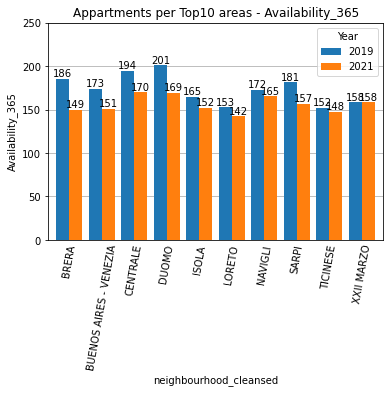

In [27]:
dfMilan_comparison3.plot.bar(width = 0.8, rot = 80, zorder = 2)

plt.title('Appartments per Top10 areas - Availability_365')
plt.ylabel('Availability_365')

plt.grid(axis = 'y')
plt.tick_params(axis = 'x', length = 0)
plt.ylim(0, 250)

for bar in plt.gca().patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    label = '{:.0f}'.format(y)
    plt.text(x = x, y = y + 0.3, s = label, va = 'bottom', ha = 'center')

Myös asuntojen saatavuus tarjoaa yllätyksen. Missään tarkastellussa alueessa ei ole edellisen vuoden aikainen asuntojen saatavuus ollut suurempi 2021 verraten 2019. Osassa alueista nähdään jopa merkittävästi vähemmän saatavuutta pandemian aikana.

Voimme siis päätellä, että Milanon suosituimpien alueiden keskihinnat ovat jopa kohonneet pandemian aikana eikä pandemia ole myöskään vaikuttanut suosittujen alueiden menekkiin.

## Koneoppiminen

Tässä osiossa katsotaan vielä lineaarisen regression avulla mitkä tekijät vaikuttavat Milanon asuntojen hintoihin 2019 ja 2021. Katsotaan ensiksi juurikin miten eri muuttujat korreloivat kyseisten vuosien datoissa.

In [28]:
dfMilan.groupby('Year').corr()['price']

Year                      
2019  id                      0.005287
      accommodates            0.225010
      bedrooms                0.262133
      beds                    0.207599
      price                   1.000000
      availability_365        0.050159
      number_of_reviews      -0.085476
      review_scores_rating   -0.036871
2021  id                     -0.025906
      accommodates            0.181890
      bedrooms                0.174259
      beds                    0.169672
      price                   1.000000
      availability_365       -0.009639
      number_of_reviews      -0.046223
      review_scores_rating   -0.014960
Name: price, dtype: float64

Huomataan, että tutkimuksen kannalta yksi tärkeimmistä selittävistä tekijöistä "neighbourhood_cleansed" ei nouse korrelaatioihin. Tämä johtuu datatyypistä ja arvoista. Siivotaan siis vielä kerran dataa ja muutetaan arvot ja datatyyppi numeroiksi. 

In [29]:
display(dfMilan.dtypes)

id                          int64
host_is_superhost          object
neighbourhood_cleansed     object
room_type                  object
accommodates                int64
bedrooms                  float64
beds                      float64
price                     float64
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
Year                        int64
dtype: object

In [30]:
dfMilan['neighbourhood_cleansed']=dfMilan['neighbourhood_cleansed'].replace(
        ['NAVIGLI', 
        'SARPI',
         'TICINESE',
         'BUENOS AIRES - VENEZIA',
         'CENTRALE',
         'XXII MARZO',
         'BRERA',
         'DUOMO',
         'ISOLA',
         'LORETO'],
        [1,2,3,4,5,6,7,8,9,10])

#NAVIGLI=1
#SARPI=2
#TICINESE=3
#BUENOS AIRES - VENEZIA=4
#CENTRALE=5
#XXII MARZO=6
#BRERA=7
#DUOMO=8
#ISOLA=9
#LORETO=10
    
dfMilan['neighbourhood_cleansed'].astype('int64')
display(dfMilan.dtypes)

id                          int64
host_is_superhost          object
neighbourhood_cleansed      int64
room_type                  object
accommodates                int64
bedrooms                  float64
beds                      float64
price                     float64
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
Year                        int64
dtype: object

In [31]:
dfMilan.groupby('Year').corr()['price']

Year                        
2019  id                        0.005287
      neighbourhood_cleansed    0.041449
      accommodates              0.225010
      bedrooms                  0.262133
      beds                      0.207599
      price                     1.000000
      availability_365          0.050159
      number_of_reviews        -0.085476
      review_scores_rating     -0.036871
2021  id                       -0.025906
      neighbourhood_cleansed    0.010751
      accommodates              0.181890
      bedrooms                  0.174259
      beds                      0.169672
      price                     1.000000
      availability_365         -0.009639
      number_of_reviews        -0.046223
      review_scores_rating     -0.014960
Name: price, dtype: float64

Nyt saatiin myös "neighbourhood_cleansed" (alue) muuttuja mukaan korrelaatioon. Huomataan, että suurin korrelaatio hintaan näyttäisi olevan makuuhuoneilla, sängyillä ja mahdollisilla majoitettavien määrällä. Alueella on vain hieman korrelaatiota hintaan. Huomataan myös, että arvostelujen määrällä sekä niiden arvioinnilla on negatiivinen vaikutus hintaan. Vuodesta 2019 vuoteen 2021 huomataan myös, että korrelaatiot (positiiviset, että negatiiviset) ovat hieman vähentyneet, eli vuonna 2021 muuttujat selittävät hintaa huonommin kuin 2019. Kuitenkaan suurta muutosta muuttujien korrelaatioissa hintaan ei huomata.

Muodostetaan näiden tietojen pohjalta lineaariset regressio-kuvaajat. Teemme kuvaajat meitä kiinnostavien korrelaatioiden välille,

1) hinnan ja alueen
2) hinnan ja vuoden
3) hinnan ja arvostelumäärän
4) hinnan ja sänkyjen

Huomataan, että tässä kohtaa käytän datasettiä, jossa molemmat vuodet ovat yhdistettynä. Tämä koska yllä huomattiin korrelaatioiden olevan samansuuntaiset molempina tarkasteluvuosina. Hinnan ylärajana graafissa on käytetty kuvaajan sopivia arvoja, sillä joissain tapauksissasuuremmat hinnat eivät ole yleisiä ja rikkovat visualisointia. 

<function matplotlib.pyplot.show(close=None, block=None)>

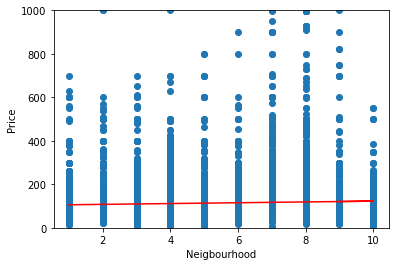

In [32]:
lr = linear_model.LinearRegression()
x = dfMilan['neighbourhood_cleansed'].values[:, np.newaxis]
y = dfMilan['price']

classifier = lr.fit(x,y)
plt.scatter(x,y)
plt.plot(x, classifier.predict(x), color = 'red')
plt.xlabel('Neigbourhood')
plt.ylabel('Price')
plt.ylim(0,1000)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

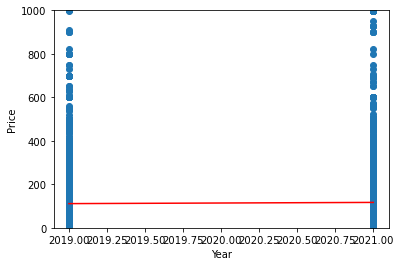

In [33]:
lr = linear_model.LinearRegression()
x = dfMilan['Year'].values[:, np.newaxis]
y = dfMilan['price']

classifier = lr.fit(x,y)
plt.scatter(x,y)
plt.plot(x, classifier.predict(x), color = 'red')
plt.xlabel('Year')
plt.ylabel('Price')
plt.ylim(0,1000)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

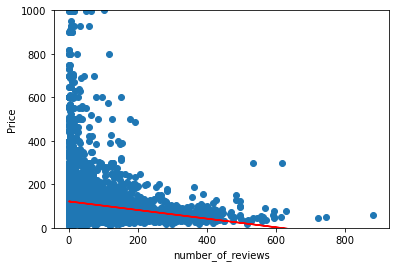

In [34]:
lr = linear_model.LinearRegression()
x = dfMilan['number_of_reviews'].values[:, np.newaxis]
y = dfMilan['price']

classifier = lr.fit(x,y)
plt.scatter(x,y)
plt.plot(x, classifier.predict(x), color = 'red')
plt.xlabel('number_of_reviews')
plt.ylabel('Price')
plt.ylim(0,1000)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

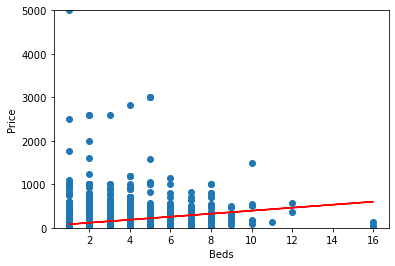

In [35]:
lr = linear_model.LinearRegression()
x = dfMilan['beds'].values[:, np.newaxis]
y = dfMilan['price']

classifier = lr.fit(x,y)
plt.scatter(x,y)
plt.plot(x, classifier.predict(x), color = 'red')
plt.xlabel('Beds')
plt.ylabel('Price')
plt.ylim(0,5000)
plt.show

Lineaarinen regressio valittujen muuttujien ja hinnan välillä kertoo seuraavaa.

1) Alueen ja hinnan välillä ei tosiaan visuaalisestikaan näytä olevan korrelaatiota, pisteet eivät istu suoralle
2) Myöskään hinnan ja vuoden välillä ei ole havaittavaa korrelaatiota
3) Kuvaajasta näkyy selkeästi, että mitä enemmän arvosteluja sitä pienempi hinta. Tämä tuntuu järkevältä, sillä yleensä kalliimmilla asunnoilla on vähemmän kysyntää ja potentiaalisia arvostelijoita.
4) Sänkyjen määrän ja hinnan välillä nähdään selkeämmin riippuvuutta, mutta siitä huolimatta vaihtelua on paljon

## Toimeenpano

Harjoitustyö tähtäsi pandemian vaikutusten selvittämiseen Airbnb-datan pohjalta. Kohdekaupungiksi valikoitui Milano joka on yksi Euroopan pahiten pandemiasta kärsineitä kaupunkeja ja hypoteesinä oli, että pandemia olisi laskenut Airbnb-asuntojen hintoja ja vaikuttanut niiden menekkiin. 

Milanoa koskien haettiin Aidbnb-listauksista dataa vuoden 2019 helmikuusta (ennen pandemiaa) ja 2021 helmikuusta (pandemian aikana/vuosi alkamisesta). Nämä datasetit yhdistettiin ja datasta tutkittiin kuvailevan analytiikan ja lineaarisen regression avulla hintaan vaikuttavia tekijöitä ja pandemian aiheuttamia muutoksia. Tutkimus keskitettiin Milanon kymmeneen suosituimpaan asuinalueeseen Airbnb-ilmoituksien mielessä.

Hieman yllättäen tuloksista nähdään, että pandemia ei ole vaikuttanut kielteisesti hintojen kehitykseen eikä menekkiin. Päinvastoin vuodesta 2019 vuoteen 2021 yöpymisten keskihinnat ovat nousseet ja yöpymisten saatavuus laskenut, vaikka ilmoitettujen asuntojen määrässä ei ole juuri muutosta. Eli pandemiankin aikana Milanon Airbnb-asuntoja on vuokrattu normaalin, jopa kiihtyvään tahtiin hieman aiempaa korkemmalla keskihinnalla.

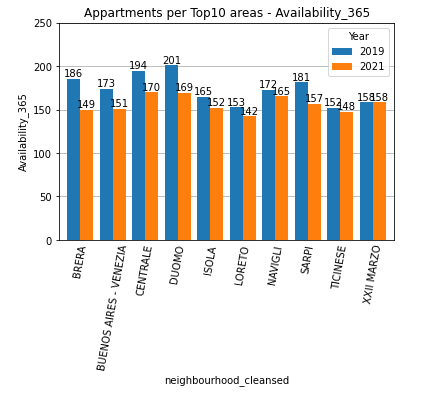

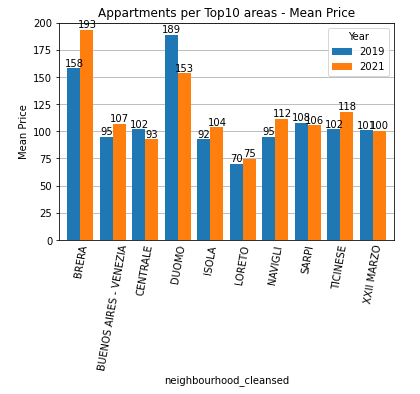

Tutkimuksen perusteella voidaan olettaa, että Milanolaisen Airbnb-asunnon omistaja ei ole kärsinyt pandemiasta tulonmenetyksiä eikä asuntojen arvotkaan ole romahtaneet, kysynnän pysyessä hyvänä. Airbnb-palvelujen käyttäjälle tutkimus osoittaa, että majoitus ei ole halvempaa pandemian aikanakaan, joten oletettavasti matkustusrajoitusten päättymisen jälkeen ja kysynnän ennestään kasvaessa, hinnat tulevat todennäköisesti entisestään nousemaan. 

Tutkimuksen perusteella voidaankin todeta, että

1) Pandemia ei vaikuta Airbnb-asunnon omistamisen sijoitusmielekkyyteen Milanossa

2) Airbnb-palvelujen käyttäjä ei ole hyötynyt pandemian aikana halvemmista hinnasta ja paremmasta saatavuudesta

3) Pandemian jälkeen hinnat todennäköisesti edelleen nousevat, kun kysyntä kasvaaa

Mikäli siis aiot matkustaa Milanoon pandemian jälkeen, majoituksen varaamista kannattaa harkita hyvissä ajoin ennakkoon. Airbnb:n kautta varattaviin huoneistoihin on myös tarjolla pandemian aikana parempia peruutusehtoja, mahdollisten viranomaissäädösten ja matkustusrajoitusten vuoksi, joten tästäkin syystä matkan suunnittelu voidaan toteuttaa poikkeusoloissakin hyvissä ajoin. 